# Data loading

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from numpy import arange, logspace

sns.set_theme(rc={'figure.figsize':(11.7,8.27)}) # A4 size

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('league-of-legends/games.csv')

In [189]:
columns_to_drop = ['gameId', 'creationTime', 'gameDuration', 'seasonId', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills',
                    't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 'firstInhibitor', 'firstBaron', 't1_dragonKills', 't2_dragonKills']

target_column = ['winner']

first_action_columns = ['firstBlood', 'firstTower', 'firstDragon', 'firstRiftHerald']

kills_columns = ['t1_riftHeraldKills', 't2_riftHeraldKills']

t1_champ_columns = ['t1_champ1id', 't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id']
t2_champ_columns = ['t2_champ1id', 't2_champ2id', 't2_champ3id', 't2_champ4id', 't2_champ5id']
champ_columns = t1_champ_columns + t2_champ_columns

t1_spell_columns = ['t1_champ1_sum1', 't1_champ1_sum2', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2']
t2_spell_columns = ['t2_champ1_sum1', 't2_champ1_sum2', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5_sum1', 't2_champ5_sum2']
spell_columns = t1_spell_columns + t2_spell_columns

t1_ban_columns = ['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5']
t2_ban_columns = ['t2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']
ban_columns = t1_ban_columns + t2_ban_columns

team_selection_columns = first_action_columns # value to encode into different columns (0 means no action, 1 means action by team 1, 2 means action by team 2)

columns_to_encode = champ_columns + spell_columns + ban_columns + team_selection_columns # having this much columns to encode may slow down the training process, some columns may need to be dropped

light_columns_to_encode = champ_columns + team_selection_columns # columns to keep inside columns_to_encode if light encoding set to True

columns_to_normalize = kills_columns

# Data understanding

In [190]:
print(data.columns)
print(data.head())

print(data.isnull().sum())
data.describe().round(2)

Index(['gameId', 'creationTime', 'gameDuration', 'seasonId', 'winner',
       'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1',
       't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2',
       't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1',
       't1_champ5_sum2', 't1_towerKills', 't1_inhibitorKills', 't1_baronKills',
       't1_dragonKills', 't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3',
       't1_ban4', 't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHer

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
count,5.149000e+04,5.149000e+04,51490.00,51490.0,51490.00,51490.00,51490.00,51490.00,51490.00,51490.00,...,51490.00,51490.00,51490.00,51490.00,51490.00,51490.00,51490.00,51490.00,51490.00,51490.00
mean,3.306223e+09,1.502926e+12,1832.36,9.0,1.49,1.47,1.45,1.31,0.93,1.44,...,5.55,0.99,0.41,1.40,0.24,108.22,107.91,108.69,108.63,108.07
std,2.946096e+07,1.978026e+09,512.02,0.0,0.50,0.52,0.54,0.68,0.84,0.57,...,3.86,1.26,0.61,1.22,0.43,102.55,102.87,102.59,103.35,102.76
min,3.214824e+09,1.496892e+12,190.00,9.0,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00
25%,3.292218e+09,1.502021e+12,1531.00,9.0,1.00,1.00,1.00,1.00,0.00,1.00,...,2.00,0.00,0.00,0.00,0.00,38.00,37.00,38.00,38.00,38.00
50%,3.320021e+09,1.503844e+12,1833.00,9.0,1.00,1.00,1.00,1.00,1.00,1.00,...,6.00,0.00,0.00,1.00,0.00,90.00,90.00,90.00,90.00,90.00
75%,3.327099e+09,1.504352e+12,2148.00,9.0,2.00,2.00,2.00,2.00,2.00,2.00,...,9.00,2.00,1.00,2.00,0.00,141.00,141.00,141.00,141.00,141.00
max,3.331833e+09,1.504707e+12,4728.00,9.0,2.00,2.00,2.00,2.00,2.00,2.00,...,11.00,10.00,4.00,6.00,1.00,516.00,516.00,516.00,516.00,516.00


<Figure size 1170x827 with 0 Axes>

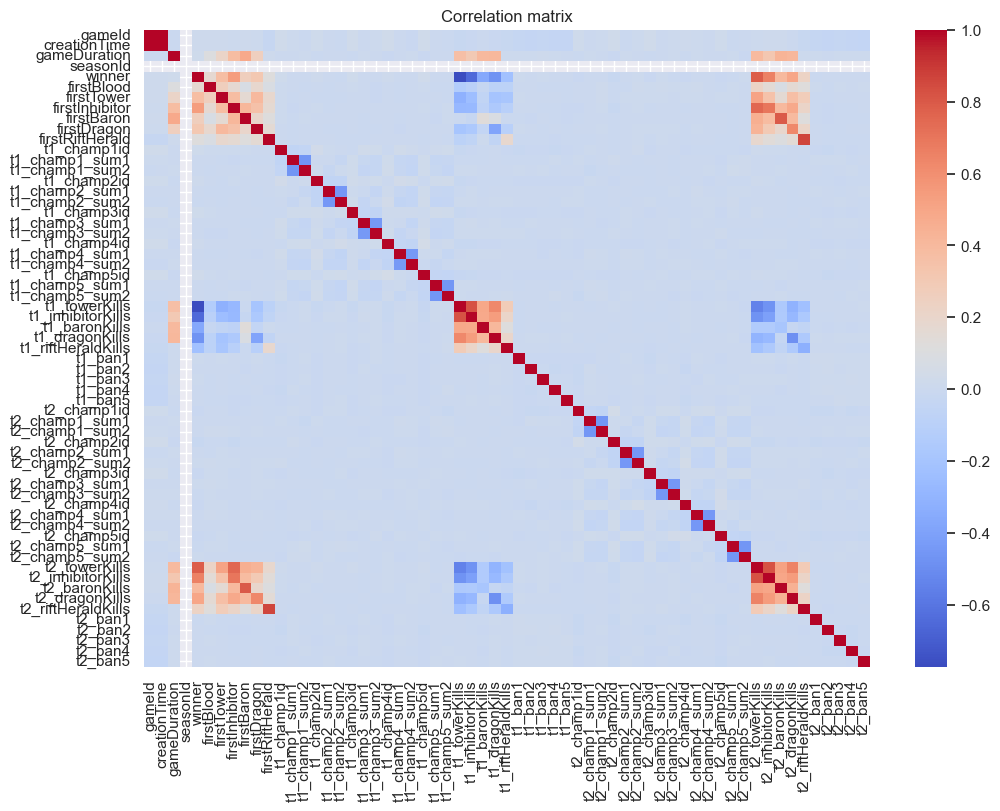

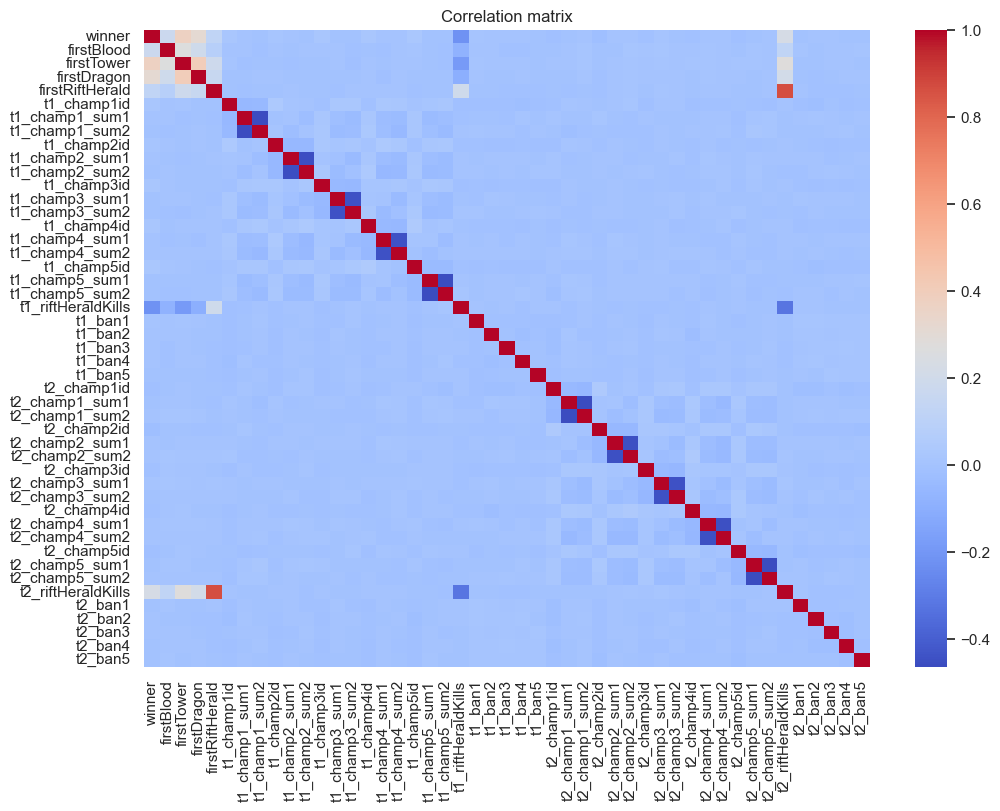

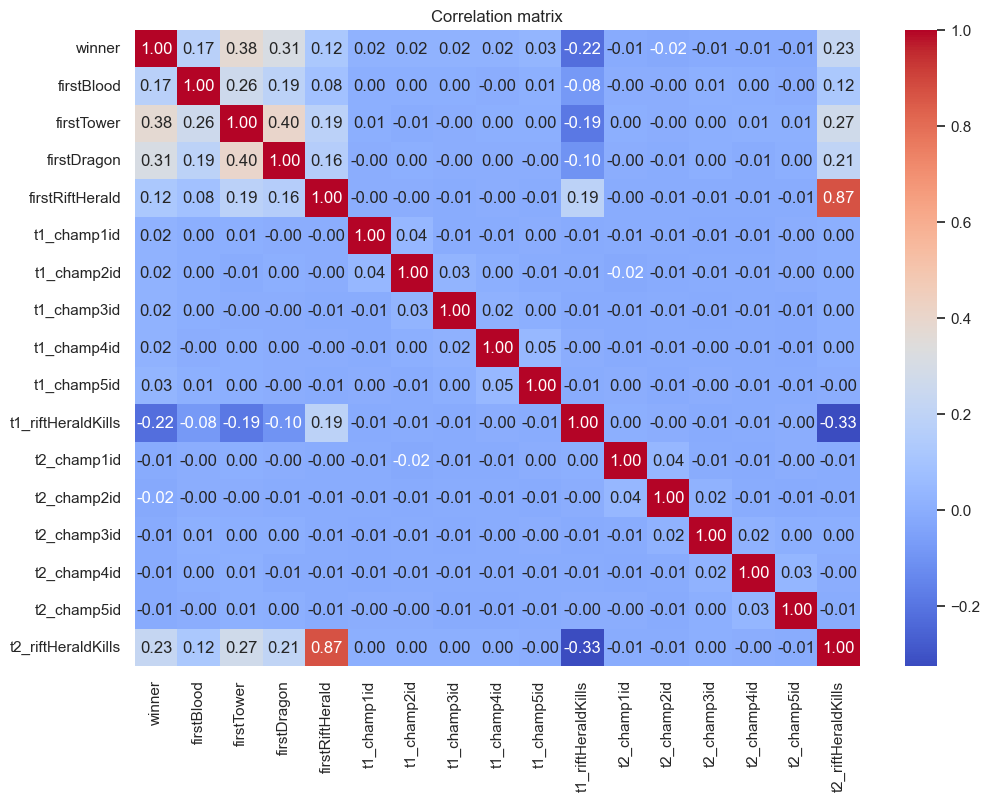

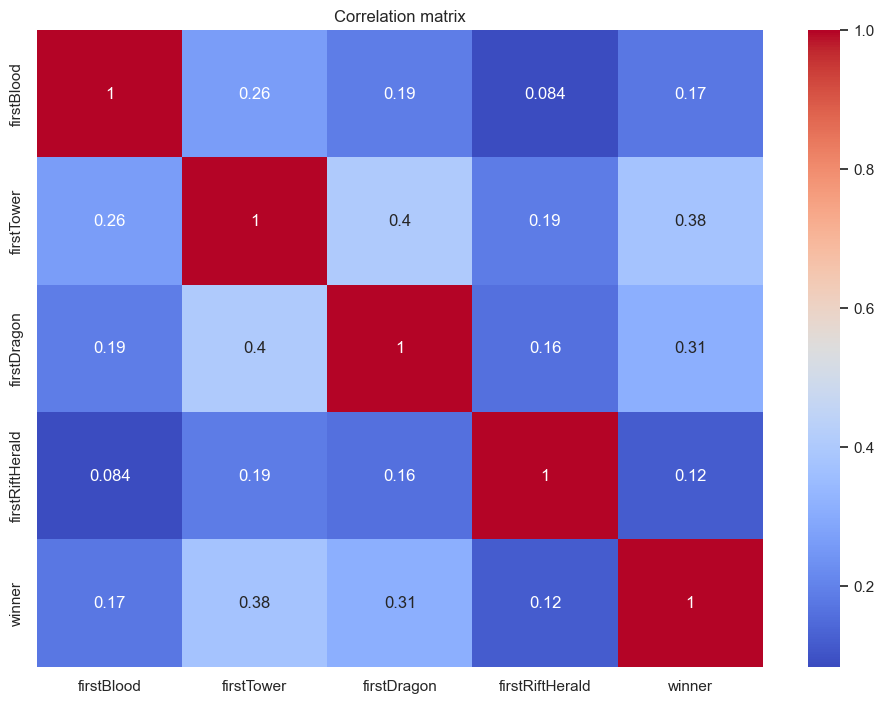

<Figure size 1170x827 with 0 Axes>

In [191]:
sns.heatmap(data.corr(), cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Correlation matrix')
plt.figure()
data_drop = data.drop(columns_to_drop, axis=1)

data_without_bans_and_spells = data.drop(columns_to_drop + spell_columns + ban_columns, axis=1)

first_data = data.get(first_action_columns + target_column)

sns.heatmap(data_drop.corr(), cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Correlation matrix')
plt.figure()

sns.heatmap(data_without_bans_and_spells.corr(), cmap='coolwarm', xticklabels=True, yticklabels=True, annot=True, fmt=".2f")
plt.title('Correlation matrix')
plt.figure()

sns.heatmap(first_data.corr(), cmap='coolwarm', xticklabels=True, yticklabels=True, annot=True)
plt.title('Correlation matrix')
plt.figure()

# sns.pairplot(data_without_bans_and_spells.sample(1000), hue='winner')
# plt.title('Pairplot')
# plt.figure()


# Data preprocessing

## removing unecessary columns and splitting into ipnut and target values

In [192]:
# drop columns that are not useful for the model
data.drop(columns_to_drop, axis=1, inplace=True)

#drop entries where firstTower is 0
data.drop(data[data['firstTower'] == 0].index, inplace=True)


#get number of entries
entries = data.shape[0]
max_entries = 10000

if entries > max_entries:
    #print("Removing ", entries - max_entries, " entries")

    # Drop some entries to have a smaller training and testing dataset
    data = data.sample(n = max_entries)
    data.reset_index(drop=True, inplace=True)

data[target_column] = data[target_column].replace(2, 0) # as 1 mean team 1 was first and 2 means team 2 was first, replace 2 with 0 to indicate if team 1 was first or not (simplify data preprocessing)


# print(data.head())

target = data['winner']
input = data.drop(target_column, axis=1)

## encoding values (one hot encoding)

In [193]:
# one hot encoding

from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()

def one_hot_encode(data, column):
    encoded_data = onehotencoder.fit_transform(data[column].values.reshape(-1, 1)).toarray()
    encoded_data = pd.DataFrame(encoded_data, columns=[column + '_' + str(int(i)) for i in range(encoded_data.shape[1])])
    data = data.drop(column, axis=1)
    return pd.concat([data, encoded_data], axis=1)

light_encoding = True

for column in columns_to_encode:
    if light_encoding and column not in light_columns_to_encode:
        input.drop(column, axis=1, inplace=True) # drop columns that are not in light_columns_to_encode
    else:
        input = one_hot_encode(input, column)

print(input.columns)


Index(['t1_riftHeraldKills', 't2_riftHeraldKills', 't1_champ1id_0',
       't1_champ1id_1', 't1_champ1id_2', 't1_champ1id_3', 't1_champ1id_4',
       't1_champ1id_5', 't1_champ1id_6', 't1_champ1id_7',
       ...
       'firstBlood_0', 'firstBlood_1', 'firstTower_0', 'firstTower_1',
       'firstDragon_0', 'firstDragon_1', 'firstDragon_2', 'firstRiftHerald_0',
       'firstRiftHerald_1', 'firstRiftHerald_2'],
      dtype='object', length=1392)


## normalizing values

In [194]:
# Normalizing the data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

input[columns_to_normalize] = scaler.fit_transform(input[columns_to_normalize])

print(input)

      t1_riftHeraldKills  t2_riftHeraldKills  t1_champ1id_0  t1_champ1id_1  \
0                    1.0                 0.0            0.0            0.0   
1                    0.0                 0.0            0.0            0.0   
2                    1.0                 0.0            0.0            0.0   
3                    0.0                 0.0            0.0            0.0   
4                    0.0                 1.0            0.0            0.0   
...                  ...                 ...            ...            ...   
9995                 0.0                 0.0            0.0            0.0   
9996                 0.0                 0.0            0.0            0.0   
9997                 0.0                 0.0            0.0            0.0   
9998                 1.0                 0.0            0.0            0.0   
9999                 1.0                 0.0            0.0            0.0   

      t1_champ1id_2  t1_champ1id_3  t1_champ1id_4  t1_champ1id_

## class balancing

1       0
4       0
5       0
6       0
8       0
       ..
2635    1
8764    1
5003    1
9135    1
1656    1
Name: winner, Length: 9802, dtype: int64


<Axes: xlabel='winner', ylabel='count'>

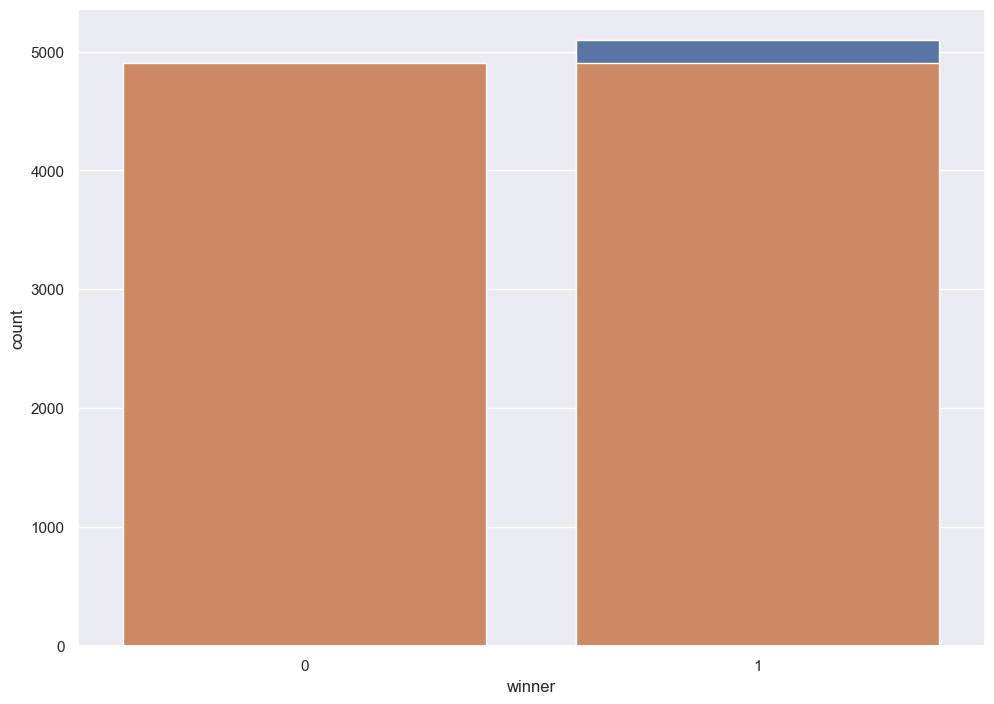

In [195]:
# Class balancing

sns.countplot(x = target)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
input, target = rus.fit_resample(input, target)

print(target)

sns.countplot(x = target)

# Training and Testing

## spliting

In [196]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.3)


In [197]:
def make_report(model, model_name):
    y_pred = model.predict(X_test)
    macc = accuracy_score(y_test, y_pred) * 100
    print(f"{model_name} - Accuracy: {macc:.3f}.")
    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.title("Confusion Matrix", size = 12)

## LR Model

Logistic Regression - Accuracy: 68.208.

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      1486
           1       0.68      0.68      0.68      1455

    accuracy                           0.68      2941
   macro avg       0.68      0.68      0.68      2941
weighted avg       0.68      0.68      0.68      2941



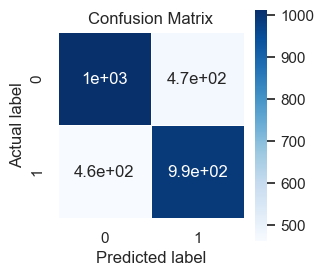

In [198]:
#LR
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

make_report(log_reg, "Logistic Regression")

## KNN Model

KNN - Accuracy: 68.344.

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1486
           1       0.68      0.67      0.68      1455

    accuracy                           0.68      2941
   macro avg       0.68      0.68      0.68      2941
weighted avg       0.68      0.68      0.68      2941



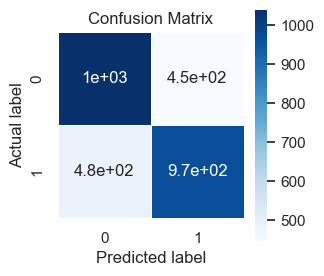

In [199]:
#KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

make_report(knn, "KNN")

## LR HP Tunning

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Tuned Logistic Regression Parameters: {'C': np.float64(0.1), 'penalty': 'l2', 'solver': 'lbfgs', 'tol': np.float64(0.001)}
Best score is 0.7316717679638535
Logistic Regression HP Tuned - Accuracy: 71.676.

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1486
           1       0.72      0.71      0.71      1455

    accuracy                           0.72      2941
   macro avg       0.72      0.72      0.72      2941
weighted avg       0.72      0.72      0.72      2941



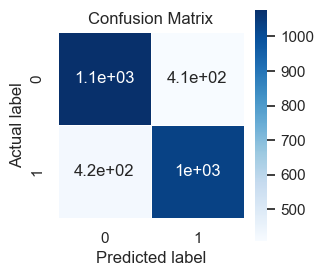

In [200]:
# LR HP Tunning
log_reg = LogisticRegression(max_iter=3000)

param_grid = {
    'C': logspace(-3, 1, 5),
    'tol': logspace(-4, -2, 2),
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga'],
    'penalty': ['l1', 'l2']
    
}

log_reg_cv = GridSearchCV(log_reg, param_grid, cv=4, n_jobs = 4, verbose = 1)
log_reg_cv.fit(X_train, y_train)

print("Tuned Logistic Regression Parameters: {}".format(log_reg_cv.best_params_))
print("Best score is {}".format(log_reg_cv.best_score_))

make_report(log_reg_cv, "Logistic Regression HP Tuned")

## KNN HP Tunning

Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best Parameters:  {'algorithm': 'auto', 'leaf_size': np.int64(1), 'n_neighbors': np.int64(20), 'p': 2, 'weights': 'uniform'}
Best Scores:  0.719720157411456
KNN HP Tuned - Accuracy: 70.520.

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      1486
           1       0.72      0.66      0.69      1455

    accuracy                           0.71      2941
   macro avg       0.71      0.70      0.70      2941
weighted avg       0.71      0.71      0.70      2941



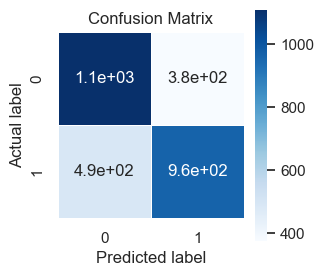

In [ ]:
#HP Tunning
knn = KNeighborsClassifier()

parameters = {
    'n_neighbors': arange(10, 30, 5),
    'weights' : ['distance', 'uniform'],
    'algorithm' : ['auto'],
    'leaf_size': arange(1, 10, 2),
    'p' : [2] # p=1 for manhattan_distance and p=2 for euclidean_distance
}

knn_grid = GridSearchCV(estimator = knn, param_grid = parameters, cv = 4, n_jobs = 4, verbose = 1)
knn_grid.fit(X_train, y_train)

print("\nBest Parameters: ", knn_grid.best_params_)
print("Best Scores: ", knn_grid.best_score_) 

make_report(knn_grid, "KNN HP Tuned")